# Тематическая классификация длинных текстов - TFIDF и LogReg

In [17]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

In [88]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

# upd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from pymystem3 import Mystem
from string import punctuation

## Предобработка текстов и подготовка признаков

In [89]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [90]:
mystem = Mystem() 
stop_words = set(stopwords.words('english'))

In [91]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token != " " and token.strip() not in punctuation]
    return tokens

In [92]:
preprocess_text('hello, my dear! nice to meet you')

['hello', 'dear', 'nice', 'meet']

In [93]:
preprocess_text(train_source['data'][0])

['lerxst',
 'wam',
 'umd',
 'edu',
 'thing',
 'subject',
 'car',
 '!?',
 'nntp',
 'posting',
 'host',
 'rac3',
 'wam',
 'umd',
 'edu',
 'organization',
 'university',
 'maryland',
 'college',
 'park',
 'lines',
 '15',
 'wondering',
 'anyone',
 'could',
 'enlighten',
 'car',
 'saw',
 'day',
 '2',
 'door',
 'sports',
 'car',
 'looked',
 'late',
 '60s',
 'early',
 '70s',
 'called',
 'bricklin',
 'doors',
 'really',
 'small',
 'addition',
 'front',
 'bumper',
 'separate',
 'rest',
 'body',
 'know',
 'anyone',
 'tellme',
 'model',
 'name',
 'engine',
 'specs',
 'years',
 'production',
 'car',
 'made',
 'history',
 'whatever',
 'info',
 'funky',
 'looking',
 'car',
 'please',
 'e',
 'mail',
 'thanks',
 'il',
 '   ---- ',
 'brought',
 'neighborhood',
 'lerxst',
 ' ----\n']

In [94]:
train_tokenized = [preprocess_text(sentence) for sentence in train_source['data']]
test_tokenized = [preprocess_text(sentence) for sentence in test_source['data']]

print(' '.join(train_tokenized[0]))

lerxst wam umd edu thing subject car !? nntp posting host rac3 wam umd edu organization university maryland college park lines 15 wondering anyone could enlighten car saw day 2 door sports car looked late 60s early 70s called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please e mail thanks il    ----  brought neighborhood lerxst  ----



In [95]:
len(train_tokenized)

11314

In [38]:
# # stopwords filter
# stop_words = stopwords.words('english')

# train_clear = []
# test_clear=[]

# for i in train_tokenized:
#     i = [w for w in i if not w.lower() in stop_words]
#     train_clear.append(i)
    
# for i in test_tokenized:
#     i = [w for w in i if not w.lower() in stop_words]
#     test_clear.append(i)

# # len(train_clear)

In [135]:
MAX_DF = 0.29
MIN_COUNT = 2
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 62059
[('get', 0), ('-- \n', 1), ('think', 2), ('distribution', 3), ('also', 4), ('1', 5), ('people', 6), ('time', 7), ('2', 8), ('could', 9)]


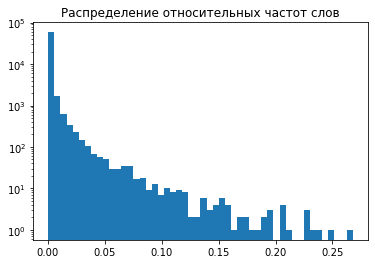

In [136]:
plt.hist(word_doc_freq, bins=50)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [137]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 62059)
Размерность матрицы признаков тестовой выборки (7532, 62059)

Количество ненулевых элементов в обучающей выборке 1308323
Процент заполненности матрицы признаков 0.19%

Количество ненулевых элементов в тестовой выборке 809593
Процент заполненности матрицы признаков 0.17%


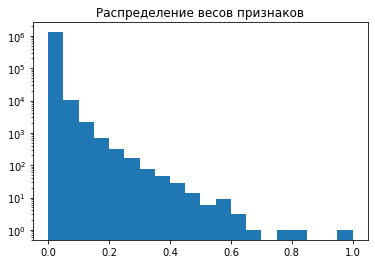

In [138]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [139]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


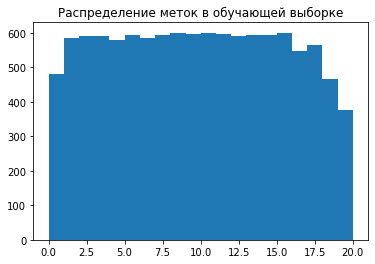

In [140]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

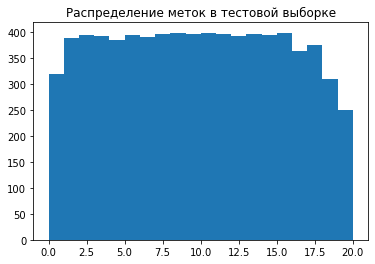

In [141]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [142]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [143]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.2, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-2,
                                            epoch_n=300,
                                            batch_size=200,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 57 итераций, 1.76 сек
Среднее значение функции потерь на обучении 2.9706140652037503
Среднее значение функции потерь на валидации 2.9425039542348763
Новая лучшая модель!

Эпоха 1
Эпоха: 57 итераций, 1.70 сек
Среднее значение функции потерь на обучении 2.888629160429302
Среднее значение функции потерь на валидации 2.8908184892252873
Новая лучшая модель!

Эпоха 2
Эпоха: 57 итераций, 1.87 сек
Среднее значение функции потерь на обучении 2.808211058901067
Среднее значение функции потерь на валидации 2.839445371376841
Новая лучшая модель!

Эпоха 3
Эпоха: 57 итераций, 1.95 сек
Среднее значение функции потерь на обучении 2.7273596378794887
Среднее значение функции потерь на валидации 2.7885246716047587
Новая лучшая модель!

Эпоха 4
Эпоха: 57 итераций, 1.90 сек
Среднее значение функции потерь на обучении 2.64742664705243
Среднее значение функции потерь на валидации 2.7380023692783557
Новая лучшая модель!

Эпоха 5
Эпоха: 57 итераций, 2.00 сек
Среднее значение функции потерь на обу

## Оценка качества

In [124]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:03<00:00, 97.67it/s] 


Среднее значение функции потерь на обучении 0.023694762960076332
Доля верных ответов 0.9993812975075128



236it [00:02, 111.95it/s]                             

Среднее значение функции потерь на валидации 1.3264509439468384
Доля верных ответов 0.7306160382368561


# Альтернативная реализация на scikit-learn

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT,
                                                      sublinear_tf=True)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [132]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.5230777669252737
Доля верных ответов 0.9823227859289376

Среднее значение функции потерь на валидации 2.6743862627937096
Доля верных ответов 0.8365639936271907
